In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
from sklearn.metrics import confusion_matrix,accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from tensorflow import keras
import matplotlib.pyplot as plt
import shap
import os
import json
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Binary classification 

In [75]:
gi_training = pd.read_parquet('../data/processed/gi_binary_training.parquet')
X = gi_training.drop(columns=['sample','disease_present'])
y = gi_training['disease_present']
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [77]:
# make search space for bayes tuning
search_spaces = {
    "max_depth": Integer(3, 8),              
    "learning_rate": Real(1e-3, 0.3, prior="log-uniform"), 
    "subsample": Real(0.5, 1.0),                
    "colsample_bytree": Real(0.5, 1.0),         
    "reg_lambda": Real(1e-3, 10.0, prior="log-uniform"),    
    "reg_alpha": Real(1e-3, 10.0, prior="log-uniform"),   
}

# create model 
bst = xgb.XGBClassifier(
    n_estimators=400, 
    max_depth=5, 
    learning_rate=0.08, 
    objective='binary:logistic',
    eval_metric = 'auc',
    tree_method = 'hist',
    )


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=bst,             
    search_spaces=search_spaces, 
    n_iter=10,                  
    scoring="roc_auc",          
    cv=cv,                     
    n_jobs=-1,                  
    verbose=1,                  
    random_state=42             
)

# fit model
opt.fit(X_train, y_train)

print(opt.best_params_)
print(opt.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
OrderedDict([('colsample_bytree', 0.705051979426657), ('learning_rate', 0.06348409107711134), ('max_depth', 8), ('reg_alpha', 0.018331515651137147), ('reg_lambda', 0.47928274405969296), ('subsample', 0.7070593162427692)])
0.847777516930832


In [79]:
#save params
dump_path = '../params/best_params_binary_gi_xgboost.json'
file_mode = 'x' if not Path(dump_path).exists() else 'w'
with open(dump_path, file_mode) as f:
    json.dump(opt.best_params_, f)

#save model
best_model = opt.best_estimator_
best_model.save_model('../saved_models/binary_gi_xgboost_model.json')


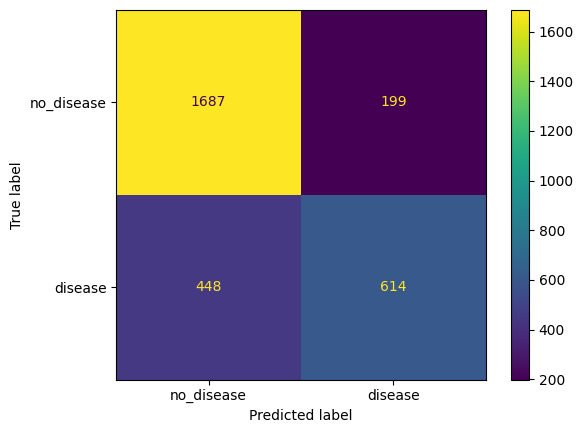

In [80]:
best_model = xgb.XGBClassifier()
best_model.load_model('../saved_models/binary_gi_xgboost_model.json')
preds = best_model.predict(X_test)
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm,display_labels=['no_disease','disease'])
cm_disp.plot()
plt.show()

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


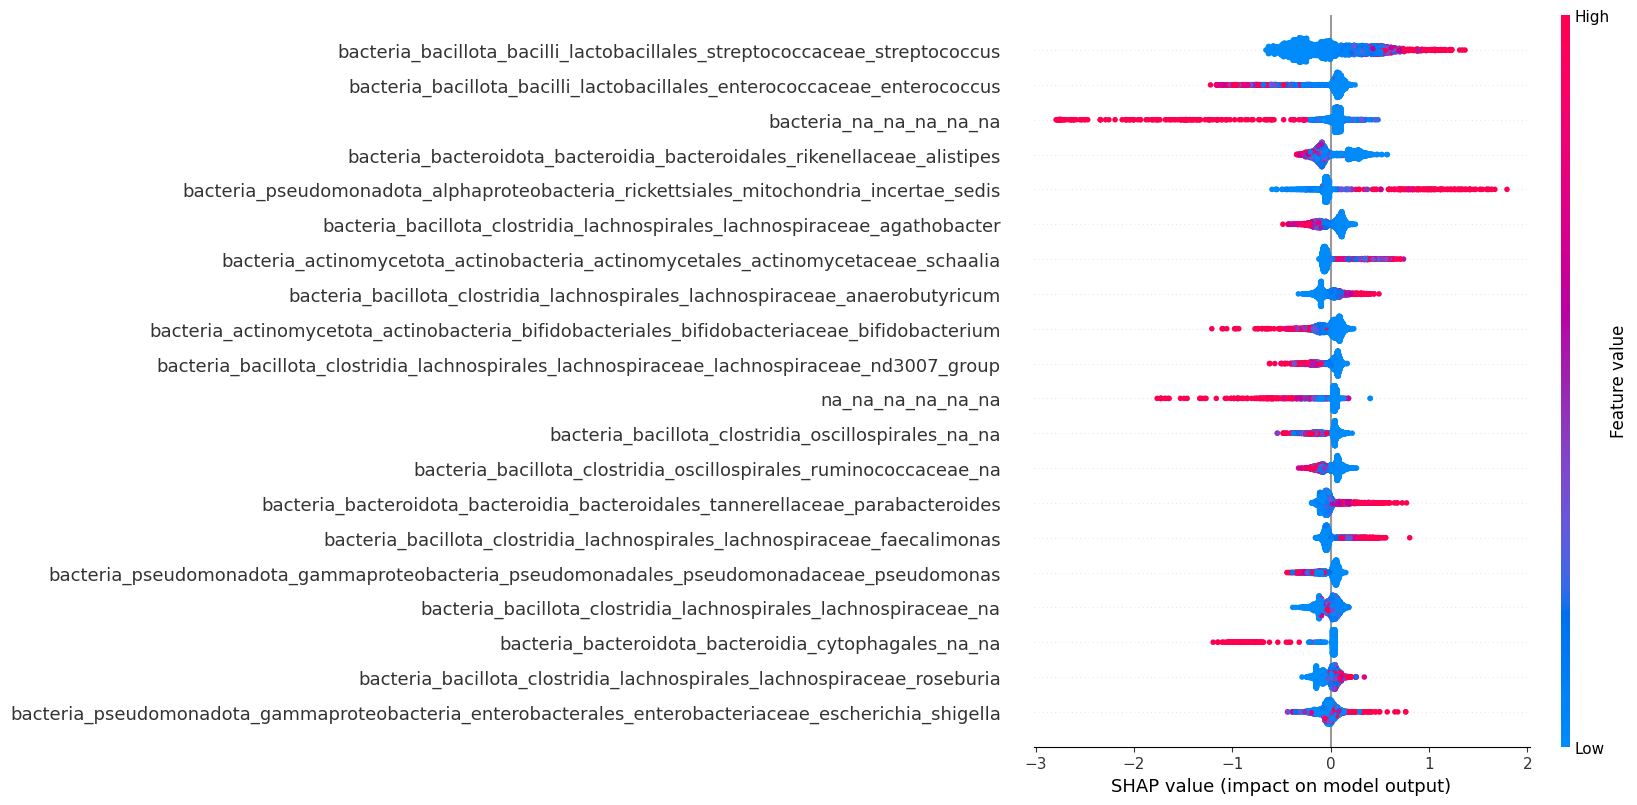

In [94]:
# compute SHAP values

shortened_names = [' '.join(taxon.split('_')[-2:]) for taxon in X_test.columns]

explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test, max_display=20, feature_names=None)